# Regularization  

Welcome to the second assignment of this week. Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not **big enough**. Sure it does well on the **training set**, but the learned network doesn't **generalize to new examples that it has never seen!**

You will learn how to Use **regularization** methods in your deep learning models.

For this purpose we are going to keep improve The previously built deep neural network model from **intialization** division. The model structure consists of four layers with with the following number of neurons ordinally [20,7,5,1] with the first three activation functions being relu while the output is activation is sigmoid. In addition, we will be employing the **cat-VS-noncat image classification problem** in our implematation.  

we will use this neural network to improve its functionality by adding the following regularization modes:

* L2 regularization mode -- controlled by a hyperparameter called **lambd**. We use "lambd" instead of "lambda" because "lambda" is a reserved keyword in Python.
* Dropout mode -- controlled by a hyperparameter called **keep_prob** which takes values less than one

**Tutorial plan**  

In this tutorial we are going to compare three different implementations as follow:  

1. Non-regularized model implemntation 
2. L2 regularization model implementation 
3. Dropout model implemenation 

**note**: It is possible to combine L2 regularization with dropout regularization, but in this tutorial we are going to examine each method separately. 

In each part, you will run this model with the correct inputs so that it calls the functions you've implemented. Let's get start.

# Related Packages importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from PIL import Image
from scipy import ndimage
# for windows os flip the forward slash (/) into backward slash (\)
os.chdir('../utils')
from lr_utils import load_dataset
from helpers import activation_fun, act_derivative, data_generator

%matplotlib inline

# Data Preparation

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 1. It's a cat picture.


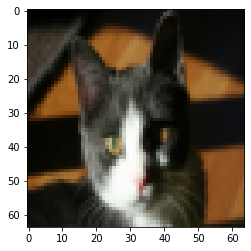

In [3]:
index = 19
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [5]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


# Neural network model and regularization  

All related functions of neural network model we prviously implemented are wrapped together in a python class for sake of implemetation simplicity.  
Our target functions are:
1. For L2 regularization:  compute_cost() and backward_prop().
2. For dropout regularization: forward_prop() and backward_prop().  

Thus, we are going to reimplement them separately and then plug it into the class to perform our expriments. Lets get start.

# L2 Regularization implemntation  

The standard way to avoid **overfitting** is called **L2 regularization**. It consists of appropriately modifying your cost function, from: $$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$ To: $$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

 Implement compute_L2cost() which computes the cost given by formula (2). To calculate $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$ , use :

*np.sum(np.square(Wl))*

**Note:** Note that you have to do this for weights from $W^{[1]}$ to $W^{[L]}$, and then multiply the result by $ \frac{1}{m} \frac{\lambda}{2} $.

In [6]:
# The previous cost computation function

def compute_cost(Y, cache):
    
    AL = cache[(list(cache.keys())[-1])]
    m = Y.shape[1]
    
    cost = np.squeeze((-1/m)*(np.dot(Y,np.log(AL).T)+ np.dot((1-Y),np.log(1-AL).T)))
    assert(cost.shape == ())
    
    return cost

In [79]:
# The new cost computation function

def compute_L2cost(Y, cache, parameters, lambd):
    
    AL = cache[(list(cache.keys())[-1])]
    m = Y.shape[1]
    weights ={}
    L2_cost = 0 
    
    regular_cost = np.squeeze((-1/m)*(np.dot(Y,np.log(AL).T)+ np.dot((1-Y),np.log(1-AL).T)))
    
    for key, val in  parameters.items():
        
        if 'W' in key:
            weights[key] = val
            L2_cost += np.sum(np.square(weights[key]))
    
    L2_cost = (lambd/2*m) * L2_cost
    
    cost = regular_cost + L2_cost
    
    assert(cost.shape == ())
    
    return cost

Of course, because you changed the cost, you have to change backward propagation as well! All the gradients have to be computed with respect to this new cost.

**Exercise:** Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1 to dWL. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m} W^2) = \frac{\lambda}{m} W$).


In [80]:
# The previous backward propagation computation function

def backward_prop(X,Y,parameters,cache, activation_order):
    
    AL = cache['A' + str(len(activation_order))]
    grads = {}
    dA =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    m = Y.shape[1]
    
    
    for l, activation in reversed(list(enumerate(activation_order))):
        
        Z = cache['Z' + str(l+1)]
        
        if l == 0:
            A_prev = X
        else:
            A_prev = cache['A' + str(l)]
            
        W = parameters['W' + str(l+1)]
        
        dZ = dA * act_derivative(Z, activation_type= activation)
        dW = (1/m) * np.dot(dZ,A_prev.T)
        db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
        dA = np.dot(W.T,dZ)
        
        grads['dW'+ str(l+1)] = dW
        grads['db'+ str(l+1)] = db
    
    return grads

In [ ]:
# The new backward propagation computation function

def L2_backward_prop(X,Y,parameters,cache, activation_order , lambd):
    
    AL = cache['A' + str(len(activation_order))]
    grads = {}
    dA =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    m = Y.shape[1]
    
    
    for l, activation in reversed(list(enumerate(activation_order))):
        
        Z = cache['Z' + str(l+1)]
        
        if l == 0:
            A_prev = X
        else:
            A_prev = cache['A' + str(l)]
            
        W = parameters['W' + str(l+1)]
        
        dZ = dA * act_derivative(Z, activation_type= activation)
        dW = (1/m) * np.dot(dZ,A_prev.T) + (lambd/m) * W
        db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
        dA = np.dot(W.T,dZ)
        
        grads['dW'+ str(l+1)] = dW
        grads['db'+ str(l+1)] = db
    
    return grads

# Dropout reglarization inmplemntation

**dropout** is a widely used regularization technique that is specific to deep learning. **It randomly shuts down some neurons in each iteration**.  

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.

**Forward propagation with dropout**

You are using a 4 layers neural network, and will add dropout only to the hidden layers. We will not apply dropout to the input layer as it is not a good practice to do so. Further, we will not add droppout or output layer as it consist of one neuron only.

**Instructions**: You would like to shut down some neurons in the hidden layers. To do that, you are going to carry out 4 Steps:

1. In lecture, we dicussed creating a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using np.random.rand() to randomly get numbers between 0 and 1. Here, you will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 0 with probability (1-keep_prob) or 1 with probability (keep_prob), by thresholding values in $D^{[1]}$ appropriately. Hint: to set all the entries of a matrix X to 0 (if entry is less than 0.5) or 1 (if entry is more than 0.5) you would do: X = (X < 0.5). Note that 0 and 1 are respectively equivalent to False and True.
3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). You can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by keep_prob. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called **inverted dropout**.)


**Backward propagation with dropout**

As before, you are training a 4 layer network. Add dropout to the hidden layers, using the masks $D^{[1]}$ to $D^{[L-1]}$ stored in the cache.

**Instruction**: Backpropagation with dropout is actually quite easy. You will have to carry out 2 Steps:

1. You had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to A1. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to dA1.
2. During forward propagation, you had divided A1 by keep_prob. In backpropagation, you'll therefore have to divide dA1 by keep_prob again (the calculus interpretation is that if $A^{[1]}$ is scaled by keep_prob, then its derivative $dA^{[1]}$ is also scaled by the same keep_prob).

Let's get it fired

In [ ]:
# The previous backward propagation computation function
def forward_prop(A_prev, parameters, activation_order):
    
    cache = {}
    
    for  l,activation in enumerate(activation_order):
        
        W = parameters['W' + str(l+1)]
        b = parameters['b' + str(l+1)]
       
        Z = np.dot(W,A_prev) + b
        A = activation_fun(Z,activation_type= activation)
        
        cache['Z' + str(l+1)]= Z
        cache['A' + str(l+1)]= A
        
        A_prev = A
    
    return cache

In [85]:
# The new forward propagation computation function
def dropout_forward_prop(A_prev, parameters, activation_order,keep_prob):
    
    cache = {}
    
    for  l,activation in enumerate(activation_order):
        
        if l != (len(list(enumerate(activation_order)))-1):
            W = parameters['W' + str(l+1)]
            b = parameters['b' + str(l+1)]
       
            Z = np.dot(W,A_prev) + b
            A = activation_fun(Z,activation_type= activation)
            
            np.random.seed(241)
            D = np.random.rand(A.shape[0],A.shape[1])
            D = D < keep_prob
            
            A = A * D
            A = A / keep_prob
            
            cache['Z' + str(l+1)]= Z
            cache['A' + str(l+1)]= A
            cache['D' + str(l+1)]= D
        
            A_prev = A
            
        else:
            W = parameters['W' + str(l+1)]
            b = parameters['b' + str(l+1)]
       
            Z = np.dot(W,A_prev) + b
            A = activation_fun(Z,activation_type= activation)   
            
            cache['Z' + str(l+1)]= Z
            cache['A' + str(l+1)]= A
        
            A_prev = A            
    
    return cache

In [414]:
# The new backward propagation computation function

def dropout_backward_prop(self,parameters,cache):
    
    AL = cache['A' + str(len(self.activation_order))]
    grads = {}
    dA =  - (np.divide(self.Y, AL) - np.divide(1 - self.Y, 1 - AL))
    m = self.Y.shape[1]
    
    for l, activation in reversed(list(enumerate(self.activation_order))):
        
        Z = cache['Z' + str(l+1)]
        
        if l == 0:
            A_prev = self.X
        else:
            A_prev = cache['A' + str(l)]
            
        W = parameters['W' + str(l+1)]
            
            
        if l == (len(self.activation_order)-1):
            dZ = dA * act_derivative(Z, activation_type= activation)
            dW = (1/m) * np.dot(dZ,A_prev.T)
            db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
            dA = np.dot(W.T,dZ)

        else:
            dZ = dA * act_derivative(Z, activation_type= activation)
            dW = (1/m) * np.dot(dZ,A_prev.T)
            db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
                              
                
            D = cache['D'+ str(l+1)]
            dA = dA * D
            dA = dA/self.keep_prob
            dA = np.dot(W.T,dZ)  

        
        grads['dW'+ str(l+1)] = dW
        grads['db'+ str(l+1)] = db
    
    return grads

In [372]:
class DeepNeuralNet:
    
    xtr, ytr, xts, yts = data_generator()

    def __init__(self, 
                 X=xtr,
                 Y=ytr,
                 initialization = 'he',
                 activation_order= ['relu','relu','sigmoid'], 
                 layer_dims = [4,3,2,1], 
                 num_iterations = 1000, 
                 learning_rate =.005, 
                 print_cost = True,
                 keep_prob = 1,
                 lambd = 0,
                 random_state =241):
        
        self.X = X
        self.Y = Y
        self.initialization = initialization
        self.layer_dims = layer_dims
        self.activation_order = activation_order
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.print_cost = print_cost
        self.keep_prob = keep_prob
        self.lambd = lambd
        self.random_state = random_state
    

    # parameters initiation
    def initialize_parameters(self):
        np.random.seed(self.random_state)
        parameters ={}
        L = len(self.layer_dims)
        for l in range(1,L):
            #Zero initialization
            
            if self.initialization == 'zeros':
                parameters['W'+ str(l)] =  np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
                parameters['b'+ str(l)] =  np.zeros((self.layer_dims[l],1))
        
            #random initialization
            elif self.initialization == 'random':
                parameters['W'+ str(l)] =  np.random.randn(self.layer_dims[l],self.layer_dims[l-1])
                parameters['b'+ str(l)] =  np.zeros((self.layer_dims[l],1))
        
            #he initialization
            elif self.initialization == 'he':
                parameters['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l - 1]) \
                * np.sqrt(2 / self.layer_dims[l - 1])
                parameters['b' + str(l)] = np.zeros((self.layer_dims[l], 1))
    
        return parameters


    def forward_prop(self,X,parameters):
        
        A_prev = X
        cache = {}
    
        for  l,activation in enumerate(self.activation_order):
        
            W = parameters['W' + str(l+1)]
            b = parameters['b' + str(l+1)]
       
            Z = np.dot(W,A_prev) + b
            A = activation_fun(Z,activation_type= activation)
        
            cache['Z' + str(l+1)]= Z
            cache['A' + str(l+1)]= A
        
            A_prev = A
    
        return cache
    
    
    def dropout_forward_prop(self, X, parameters):
        
        A_prev = X
        cache = {}
    
        for  l,activation in enumerate(self.activation_order):
        
            if  l != (len(list(enumerate(self.activation_order)))-1):
                W = parameters['W' + str(l+1)]
                b = parameters['b' + str(l+1)]
       
                Z = np.dot(W,A_prev) + b
                A = activation_fun(Z,activation_type= activation)
                
                #np.random.seed(self.random_state)
                D = np.random.rand(A.shape[0],A.shape[1])
                D = D < keep_prob
            
                A = A * D
                A = A / self.keep_prob
            
                cache['Z' + str(l+1)]= Z
                cache['A' + str(l+1)]= A
                cache['D' + str(l+1)]= D
        
                A_prev = A
            
            else:
                W = parameters['W' + str(l+1)]
                b = parameters['b' + str(l+1)]
       
                Z = np.dot(W,A_prev) + b
                A = activation_fun(Z,activation_type= activation)   
            
                cache['Z' + str(l+1)] = Z
                cache['A' + str(l+1)] = A
                
                A_prev = A            
    
        return cache
    

    def compute_cost(self, cache):
    
        AL = cache[(list(cache.keys())[-1])]
        m = self.Y.shape[1]
    
        cost = np.squeeze((-1/m)*(np.dot(self.Y,np.log(AL).T)+ np.dot((1-self.Y),np.log(1-AL).T)))
        assert(cost.shape == ())
    
        return cost
    
    
    def compute_L2cost(self,cache, parameters):
    
        AL = cache[(list(cache.keys())[-1])]
        m = self.Y.shape[1]
        weights = {}
        L2_cost = 0 
    
        regular_cost = np.squeeze((-1/m)*(np.dot(self.Y,np.log(AL).T)+ np.dot((1-self.Y),np.log(1-AL).T)))
    
        for key, val in  parameters.items():
        
            if 'W' in key:
                weights[key] = val
                L2_cost += np.sum(np.square(weights[key]))
    
        L2_cost = (self.lambd/2*m) * L2_cost
    
        cost = regular_cost + L2_cost
    
        assert(cost.shape == ())
    
        return cost
    

    def backward_prop(self,parameters,cache):
    
        AL = cache['A'+str(len(self.activation_order))]
        grads = {}
        dA =  - (np.divide(self.Y, AL) - np.divide(1 - self.Y, 1 - AL))
        m = self.Y.shape[1]
    
    
        for l, activation in reversed(list(enumerate(self.activation_order))):
        
            Z = cache['Z' + str(l+1)]
        
            if l == 0:
                A_prev = self.X
            else:
                A_prev = cache['A' + str(l)]
            
            W = parameters['W' + str(l+1)]
        
            dZ = dA * act_derivative(Z, activation_type= activation)
            dW = (1/m) * np.dot(dZ,A_prev.T)
            db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
            dA = np.dot(W.T,dZ)
        
            grads['dW'+ str(l+1)] = dW
            grads['db'+ str(l+1)] = db
    
        return grads
    
    def L2_backward_prop(self,parameters,cache):
    
        AL = cache['A'+str(len(self.activation_order))]
        grads = {}
        dA =  - (np.divide(self.Y, AL) - np.divide(1 - self.Y, 1 - AL))
        m = self.Y.shape[1]
    
    
        for l, activation in reversed(list(enumerate(self.activation_order))):
        
            Z = cache['Z' + str(l+1)]
        
            if l == 0:
                A_prev = self.X
            else:
                A_prev = cache['A' + str(l)]
            
            W = parameters['W' + str(l+1)]
        
            dZ = dA * act_derivative(Z, activation_type= activation)
            dW = (1/m) * np.dot(dZ,A_prev.T) + (self.lambd/m) * W
            db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
            dA = np.dot(W.T,dZ)
        
            grads['dW'+ str(l+1)] = dW
            grads['db'+ str(l+1)] = db
    
        return grads 
    
    
    def dropout_backward_prop(self,parameters,cache):
    
        AL = cache['A' + str(len(self.activation_order))]
        grads = {}
        dA =  - (np.divide(self.Y, AL) - np.divide(1 - self.Y, 1 - AL))
        m = self.Y.shape[1]
    
        for l, activation in reversed(list(enumerate(self.activation_order))):
        
            Z = cache['Z' + str(l+1)]
        
            if l == 0:
                A_prev = self.X
            else:
                A_prev = cache['A' + str(l)]
            
            W = parameters['W' + str(l+1)]
            
            
            if l == (len(self.activation_order)-1):
                dZ = dA * act_derivative(Z, activation_type= activation)
                dW = (1/m) * np.dot(dZ,A_prev.T)
                db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
                dA = np.dot(W.T,dZ)

            else:
                dZ = dA * act_derivative(Z, activation_type= activation)
                dW = (1/m) * np.dot(dZ,A_prev.T)
                db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
                              
                
                D = cache['D'+ str(l+1)]
                dA = dA * D
                dA = dA/self.keep_prob
                dA = np.dot(W.T,dZ)  

        
            grads['dW'+ str(l+1)] = dW
            grads['db'+ str(l+1)] = db
    
        return grads
    
    

    def optimize(self,parameters, grads):
    
        L = int(len(grads)/2)+1
    
        for l in range(1,L):
        
            W = parameters['W' + str(l)]
            b = parameters['b' + str(l)]
        
            dW = grads['dW' + str(l)]
            db = grads['db' + str(l)]
        
            parameters['W' + str(l)] = W - self.learning_rate * dW
            parameters['b' + str(l)] = b - self.learning_rate * db
    
        return parameters


    def fit(self):
        costs = []
        global parameters
        parameters = self.initialize_parameters()

        for i in range(self.num_iterations):
            
            if self.keep_prob == 1:
                cache = self.forward_prop(self.X,parameters)
            elif self.keep_prob < 1:
                cache = self.dropout_forward_prop(self.X, parameters)
                
            if self.lambd == 0:    
                cost = self.compute_cost(cache)
            else:
                cost = self.compute_L2cost(cache, parameters)
            
            assert(self.keep_prob == 1 or self.lambd == 0)
            
            if self.keep_prob == 1 and self.lambd == 0:
                grads = self.backward_prop(parameters,cache)
            elif self.keep_prob < 1:
                grads = self.dropout_backward_prop(parameters, cache)
            elif self.lambd !=0:
                grads = self.L2_backward_prop(parameters,cache)
        
            parameters = self.optimize(parameters,grads)
        
            if self.print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                costs.append(cost)
        
        # plot the loss
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per thosands)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        

    def predict(self, X=xts,Y=yts):
    
        m = X.shape[1]
        p = np.zeros((1,m))
    
        # Forward propagation
        cache = self.forward_prop(X,parameters)
        probas = cache[(list(cache.keys())[-1])]

        # convert probas to 0/1 predictions
        for i in range(0,probas.shape[1]):
            if probas[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        print("Accuracy: "  + str(round(np.sum((p == Y)/m),2)))


# Experimentation

In [290]:
#hyperparameters defination

Xtr = train_x
Ytr = train_y
Xts = test_x
Yts = test_y
initialization = 'he'
activation_order= ['relu','relu','relu','sigmoid']
layer_dims = [12288,20,7,5,1] 
num_iterations =  12100
learning_rate =.0075
random_state = 31
keep_prob = 1
lambd = 0
print_cost = True

## Non-regularized model

In [166]:
model1 = DeepNeuralNet(X= Xtr,
                      Y= Ytr, 
                      initialization= initialization,
                      activation_order= activation_order,
                      layer_dims= layer_dims,
                      num_iterations= num_iterations,
                      learning_rate= learning_rate,
                      print_cost= print_cost,
                      random_state= random_state,
                      keep_prob = keep_prob,
                      lambd = lambd)

Cost after iteration 0: 0.683272
Cost after iteration 1000: 0.547664
Cost after iteration 2000: 0.124175
Cost after iteration 3000: 0.159316
Cost after iteration 4000: 0.451184
Cost after iteration 5000: 0.222256
Cost after iteration 6000: 0.124932
Cost after iteration 7000: 0.056863
Cost after iteration 8000: 0.010842
Cost after iteration 9000: 0.005164
Cost after iteration 10000: 0.002669
Cost after iteration 11000: 0.001516
Cost after iteration 12000: 0.001151


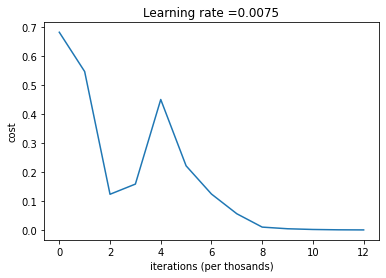

In [114]:
model1.fit()

In [115]:
model1.predict(Xtr,Ytr)

Accuracy: 1.0


In [116]:
model1.predict(Xts,Yts)

Accuracy: 0.7


## Observations  
The train accuracy is 100% while the test accuracy is 70%. This is the baseline model (you will observe the impact of regularization on this model).

## L2 regularization

In [129]:
model2 = DeepNeuralNet(X= Xtr,
                      Y= Ytr, 
                      initialization= initialization,
                      activation_order= activation_order,
                      layer_dims= layer_dims,
                      num_iterations= num_iterations,
                      learning_rate= learning_rate,
                      print_cost= print_cost,
                      random_state= random_state,
                      keep_prob = keep_prob,
                      lambd = 0.00001)

Cost after iteration 0: 0.750230
Cost after iteration 1000: 0.617388
Cost after iteration 2000: 0.547435
Cost after iteration 3000: 0.239097
Cost after iteration 4000: 0.289037
Cost after iteration 5000: 0.182320
Cost after iteration 6000: 0.125301
Cost after iteration 7000: 0.110498
Cost after iteration 8000: 0.103057
Cost after iteration 9000: 0.100793
Cost after iteration 10000: 0.099546
Cost after iteration 11000: 0.098901
Cost after iteration 12000: 0.098537


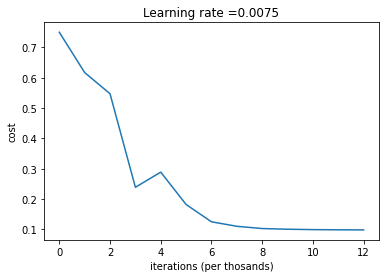

In [130]:
model2.fit()

In [135]:
model2.predict(Xtr,Ytr)

Accuracy: 1.0


In [136]:
model2.predict(Xts,Yts)

Accuracy: 0.8


## Observations:  

* It can be observed that your model has improved significantly where the test set accuracy incresed by 10% to reach 80% in comparison to the non-regularized model where the test accuracy was 70%.
* The value of $\lambda$ is a hyperparameter that you can tune using a dev set.
* L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes.

* The cost computation:
    * A regularization term is added to the cost
* The backpropagation function:
    * There are extra terms in the gradients with respect to weight matrices
* Weights end up smaller ("weight decay"):
    * Weights are pushed to smaller values.



## Dropout regularization

In [409]:
model3 = DeepNeuralNet(X= Xtr,
                      Y= Ytr, 
                      initialization= initialization,
                      activation_order= activation_order,
                      layer_dims= layer_dims,
                      num_iterations= num_iterations,
                      learning_rate= learning_rate,
                      print_cost= print_cost,
                      random_state= random_state,
                      keep_prob = 0.75,
                      lambd = lambd)

Cost after iteration 0: 0.672700
Cost after iteration 1000: 0.318447
Cost after iteration 2000: 0.397707
Cost after iteration 3000: 0.030476
Cost after iteration 4000: 0.003890
Cost after iteration 5000: 0.001808
Cost after iteration 6000: 0.001116
Cost after iteration 7000: 0.000790
Cost after iteration 8000: 0.000599
Cost after iteration 9000: 0.000478
Cost after iteration 10000: 0.000395
Cost after iteration 11000: 0.000335
Cost after iteration 12000: 0.000289


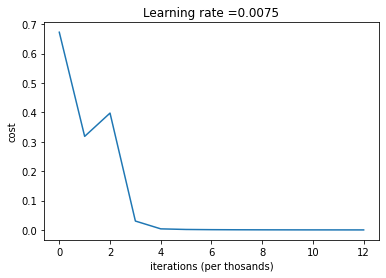

In [410]:
model3.fit()

In [411]:
model3.predict(Xtr,Ytr)

Accuracy: 1.0


In [412]:
model3.predict(Xts,Yts)

Accuracy: 0.72


## Observations  

* It can be observed that your model has improved slightly where the test set accuracy incresed by 2% to reach 72% in comparison to the non-regularized model where the test accuracy was 70%.
* The value of **keep_prob** is a hyperparameter that you can tune to improve the model performance on the test set.
* If **keep_prob** is too small, then the model will be very simple and thus underfits the training data. 



**Note**:

* A common mistake when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training.
* Deep learning frameworks like **tensorflow, PaddlePaddle, keras or caffe** come with a dropout layer implementation. Don't stress - you will soon learn some of these frameworks.

* Dropout is a regularization technique.
* You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
* Apply dropout both during forward and backward propagation.
* During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.



# Conclusion  

Congratulations for finishing this assignment! And also for revolutionizing French football. :-)

* Regularization will help you reduce overfitting.
* Regularization will drive your weights to lower values.
* L2 regularization and Dropout are two very effective regularization techniques.